# 3-6-2022
## Getting that MEC position Data 2: Nightside Acquisition and Optimized Setup
### Sequel to `Getting that MEC Data`, whose purpose to procure the 2015-20 Nightside(June to August) MECpos data.
#### Hector Salinas
---

### Goals
* Since loading up near-yearly Dayside MEC data takes ~81min, this script will serve to load such lengthy data then export desired arrays as whatever files to be loaded up in other scripts
1. Load up MEC position data(GSM coord) for corresponding date
2. Map said data onto the OMNI data to match the 5min time cadence
3. Confirm that MEC position and OMNI time arrays match
4. Export desired MEC position and time arrays
5. Also export 

* Since the goal is to export desired MEC position data, this'll run probably once if now a few times if errors occur

### Details about Dayside MEC posData from Version 1 of `Getting that MEC Data`
* (7-10-2021)As indicated by Eric, an indexing error was caused by some duplicate files with Dayside Yr2.
    * Issue was resolved by implementing a interpolation code as recommended by Eric 
* (7-12-2021)I discovered a data gap in Dayside Yr5 MEC and defined a function in `Event Searching pt2` to omit said data gap. Which occured from 11-25-19 to 12-7-19 as confimred in 'Test MMS Survey Data' notebook 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import optimize 

import numpy as np
import pytplot
import pyspedas
import copy

from pyspedas import mms, themis, cluster #importing mission modules
from pyspedas.mms import fgm, fpi, curlometer #import instrument load routines
from pyspedas import tinterpol #to match MEC data to OMNI 5min time stamps

from pytplot import tplot         # plot said tplot variables
from pytplot import tplot_names   # list tplot variables loaded
from pytplot import get_data      # extract data values from tplot variables
from pyspedas import time_string  # convert unix time to string
from pytplot import store_data    # creating tplot variables
from pytplot import options       # extra tplot features for individial tplots
from pytplot import tplot_options # global tplot options for created tplots

import time


* Test Cells for exporting MEC position data(GSM coord)
    * Using numpy to export aarrays:
        * https://stackoverflow.com/questions/37996295/how-to-save-numpy-array-into-computer-for-later-use-in-python
        * https://stackoverflow.com/questions/28439701/how-to-save-and-load-numpy-array-data-properly
        * https://machinelearningmastery.com/how-to-save-a-numpy-array-to-file-for-machine-learning/

## Section 1: Loading Up OMNI and MEC rountines for 2015-21 Nightside(June to Aug)

In [2]:
pytplot.del_data()  #delete previously loaded tplot variables
trange_yr1 = ['2015-06-01', '2015-08-31']
trange_yr2 = ['2016-06-01', '2016-08-31']
trange_yr3 = ['2017-06-01', '2017-08-31']
trange_yr4 = ['2018-06-01', '2018-08-31']
trange_yr5 = ['2019-06-01', '2019-08-31']

trange_yr6 = ['2020-06-01', '2020-08-31']
trange_yr7 = ['2021-06-01', '2021-08-31']

trangeDay_yr6 = ['2020-09-01', '2021-05-31']

 

test_date = ['2015-06-01', '2015-06-02']

def getSWMECParam(achDate, n):
# Load/return Year X OMNI data arrays with inputted tuple index and string list date range
    print('\nInput date was: %s (Year %d)' %(achDate, n) )
    omni_vars = pyspedas.omni.data(trange= achDate, datatype = '5min') #extracting data with 5min resolution
    by_time, by_val = get_data('BY_GSM') 
    mec_vars = pyspedas.mms.mec(trange = achDate, data_rate = 'srvy') # default MEC resolution will be 30 sec for survey mode data
    #Defining string variables for OMNI start and end time
    achOmni_start = time_string(by_time[0])
    achOmni_end = time_string(by_time[-1])
    print('\nConfirming loaded OMNI data range: %s to %s' %(achOmni_start[0:10], achOmni_end[0:20]));
   
    return (by_time, by_val);

By_time, By_vals = getSWMECParam(trangeDay_yr6, 6)



22-May-22 21:15:19: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2020/



Input date was: ['2020-09-01', '2021-05-31'] (Year 6)


22-May-22 21:15:20: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2020/omni_hro2_5min_20200901_v01.cdf to omni_data/hro2_5min/2020/omni_hro2_5min_20200901_v01.cdf
22-May-22 21:15:20: Download complete: omni_data/hro2_5min/2020/omni_hro2_5min_20200901_v01.cdf
22-May-22 21:15:21: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2020/omni_hro2_5min_20201001_v01.cdf to omni_data/hro2_5min/2020/omni_hro2_5min_20201001_v01.cdf
22-May-22 21:15:22: Download complete: omni_data/hro2_5min/2020/omni_hro2_5min_20201001_v01.cdf
22-May-22 21:15:23: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2020/omni_hro2_5min_20201101_v01.cdf to omni_data/hro2_5min/2020/omni_hro2_5min_20201101_v01.cdf
22-May-22 21:15:23: Download complete: omni_data/hro2_5min/2020/omni_hro2_5min_20201101_v01.cdf
22-May-22 21:15:24: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2020/omni_hro2_5min_20201201_v01.cdf to o

Time clip was applied to: IMF
Time clip was applied to: PLS
Time clip was applied to: IMF_PTS
Time clip was applied to: PLS_PTS
Time clip was applied to: percent_interp
Time clip was applied to: Timeshift
Time clip was applied to: RMS_Timeshift
Time clip was applied to: Time_btwn_obs
Time clip was applied to: F
Time clip was applied to: BX_GSE
Time clip was applied to: BY_GSE
Time clip was applied to: BZ_GSE
Time clip was applied to: BY_GSM
Time clip was applied to: BZ_GSM
Time clip was applied to: RMS_SD_B
Time clip was applied to: RMS_SD_fld_vec
Time clip was applied to: flow_speed
Time clip was applied to: Vx
Time clip was applied to: Vy
Time clip was applied to: Vz
Time clip was applied to: proton_density
Time clip was applied to: T
Time clip was applied to: NaNp_Ratio
Time clip was applied to: Pressure
Time clip was applied to: E
Time clip was applied to: Beta
Time clip was applied to: Mach_num
Time clip was applied to: Mgs_mach_num
Time clip was applied to: x
Time clip was applie

22-May-22 21:15:58: Downloading mms1_mec_srvy_l2_epht89q_20200901_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2020/09
22-May-22 21:16:07: Downloading mms1_mec_srvy_l2_epht89q_20200902_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2020/09
22-May-22 21:16:14: Downloading mms1_mec_srvy_l2_epht89q_20200903_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2020/09
22-May-22 21:16:20: Downloading mms1_mec_srvy_l2_epht89q_20200904_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2020/09
22-May-22 21:16:28: Downloading mms1_mec_srvy_l2_epht89q_20200905_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2020/09
22-May-22 21:16:33: Downloading mms1_mec_srvy_l2_epht89q_20200906_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2020/09
22-May-22 21:16:41: Downloading mms1_mec_srvy_l2_epht89q_20200907_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2020/09
22-May-22 21:16:47: Downloading mms1_mec_srvy_l2_epht89q_20200908_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2020/09
22-May-22 21:16:56: Downloading mms1_mec

22-May-22 21:21:32: Downloading mms1_mec_srvy_l2_epht89q_20201109_v2.2.2.cdf to pydata/mms1/mec/srvy/l2/epht89q/2020/11
22-May-22 21:21:37: Downloading mms1_mec_srvy_l2_epht89q_20201110_v2.2.2.cdf to pydata/mms1/mec/srvy/l2/epht89q/2020/11
22-May-22 21:21:42: Downloading mms1_mec_srvy_l2_epht89q_20201111_v2.2.1.cdf to pydata/mms1/mec/srvy/l2/epht89q/2020/11
22-May-22 21:21:48: Downloading mms1_mec_srvy_l2_epht89q_20201112_v2.2.1.cdf to pydata/mms1/mec/srvy/l2/epht89q/2020/11
22-May-22 21:21:51: Downloading mms1_mec_srvy_l2_epht89q_20201113_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2020/11
22-May-22 21:21:57: Downloading mms1_mec_srvy_l2_epht89q_20201114_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2020/11
22-May-22 21:22:02: Downloading mms1_mec_srvy_l2_epht89q_20201115_v2.2.1.cdf to pydata/mms1/mec/srvy/l2/epht89q/2020/11
22-May-22 21:22:05: Downloading mms1_mec_srvy_l2_epht89q_20201116_v2.2.1.cdf to pydata/mms1/mec/srvy/l2/epht89q/2020/11
22-May-22 21:22:09: Downloading mms1_mec

22-May-22 21:26:25: Downloading mms1_mec_srvy_l2_epht89q_20210117_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2021/01
22-May-22 21:26:28: Downloading mms1_mec_srvy_l2_epht89q_20210118_v2.2.2.cdf to pydata/mms1/mec/srvy/l2/epht89q/2021/01
22-May-22 21:26:34: Downloading mms1_mec_srvy_l2_epht89q_20210119_v2.2.2.cdf to pydata/mms1/mec/srvy/l2/epht89q/2021/01
22-May-22 21:26:41: Downloading mms1_mec_srvy_l2_epht89q_20210120_v2.2.1.cdf to pydata/mms1/mec/srvy/l2/epht89q/2021/01
22-May-22 21:26:50: Downloading mms1_mec_srvy_l2_epht89q_20210121_v2.2.1.cdf to pydata/mms1/mec/srvy/l2/epht89q/2021/01
22-May-22 21:26:56: Downloading mms1_mec_srvy_l2_epht89q_20210122_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2021/01
22-May-22 21:27:01: Downloading mms1_mec_srvy_l2_epht89q_20210123_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2021/01
22-May-22 21:27:05: Downloading mms1_mec_srvy_l2_epht89q_20210124_v2.2.1.cdf to pydata/mms1/mec/srvy/l2/epht89q/2021/01
22-May-22 21:27:08: Downloading mms1_mec

22-May-22 21:31:52: Downloading mms1_mec_srvy_l2_epht89q_20210327_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2021/03
22-May-22 21:32:01: Downloading mms1_mec_srvy_l2_epht89q_20210328_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2021/03
22-May-22 21:32:05: Downloading mms1_mec_srvy_l2_epht89q_20210329_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2021/03
22-May-22 21:32:08: Downloading mms1_mec_srvy_l2_epht89q_20210330_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2021/03
22-May-22 21:32:12: Downloading mms1_mec_srvy_l2_epht89q_20210331_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2021/03
22-May-22 21:32:16: Downloading mms1_mec_srvy_l2_epht89q_20210401_v2.2.1.cdf to pydata/mms1/mec/srvy/l2/epht89q/2021/04
22-May-22 21:32:19: Downloading mms1_mec_srvy_l2_epht89q_20210402_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2021/04
22-May-22 21:32:22: Downloading mms1_mec_srvy_l2_epht89q_20210403_v2.2.0.cdf to pydata/mms1/mec/srvy/l2/epht89q/2021/04
22-May-22 21:32:26: Downloading mms1_mec

Time clip was applied to: PR-FLX_60
Loaded variables:
mms1_mec_dipole_tilt
mms1_mec_gmst
mms1_mec_mlat
mms1_mec_mlt
mms1_mec_l_dipole
mms1_mec_quat_eci_to_bcs
mms1_mec_quat_eci_to_dbcs
mms1_mec_quat_eci_to_dmpa
mms1_mec_quat_eci_to_smpa
mms1_mec_quat_eci_to_dsl
mms1_mec_quat_eci_to_ssl
mms1_mec_L_vec
mms1_mec_Z_vec
mms1_mec_P_vec
mms1_mec_L_phase
mms1_mec_Z_phase
mms1_mec_P_phase
mms1_mec_kp
mms1_mec_dst
mms1_mec_earth_eclipse_flag
mms1_mec_moon_eclipse_flag
mms1_mec_r_eci
mms1_mec_v_eci
mms1_mec_r_gsm
mms1_mec_v_gsm
mms1_mec_quat_eci_to_gsm
mms1_mec_r_geo
mms1_mec_v_geo
mms1_mec_quat_eci_to_geo
mms1_mec_r_sm
mms1_mec_v_sm
mms1_mec_quat_eci_to_sm
mms1_mec_r_gse
mms1_mec_v_gse
mms1_mec_quat_eci_to_gse
mms1_mec_r_gse2000
mms1_mec_v_gse2000
mms1_mec_quat_eci_to_gse2000
mms1_mec_geod_lat
mms1_mec_geod_lon
mms1_mec_geod_height
mms1_mec_r_sun_de421_eci
mms1_mec_r_moon_de421_eci
mms1_mec_fieldline_type
mms1_mec_bsc_gsm
mms1_mec_loss_cone_angle_s
mms1_mec_loss_cone_angle_n
mms1_mec_pfs_geod_la

In [3]:
r_time, mecr = get_data('mms1_mec_r_gse')
#Noting loaded mec variables 30s resolution
print(time_string(r_time[:10]))

['2020-09-01 00:00:00.000000', '2020-09-01 00:00:30.000000', '2020-09-01 00:01:00.000000', '2020-09-01 00:01:30.000000', '2020-09-01 00:02:00.000000', '2020-09-01 00:02:30.000000', '2020-09-01 00:03:00.000000', '2020-09-01 00:03:30.000000', '2020-09-01 00:04:00.000000', '2020-09-01 00:04:30.000000']


0 : IMF
1 : PLS
2 : IMF_PTS
3 : PLS_PTS
4 : percent_interp
5 : Timeshift
6 : RMS_Timeshift
7 : Time_btwn_obs
8 : F
9 : BX_GSE
10 : BY_GSE
11 : BZ_GSE
12 : BY_GSM
13 : BZ_GSM
14 : RMS_SD_B
15 : RMS_SD_fld_vec
16 : flow_speed
17 : Vx
18 : Vy
19 : Vz
20 : proton_density
21 : T
22 : NaNp_Ratio
23 : Pressure
24 : E
25 : Beta
26 : Mach_num
27 : Mgs_mach_num
28 : x
29 : y
30 : z
31 : BSN_x
32 : BSN_y
33 : BSN_z
34 : AE_INDEX
35 : AL_INDEX
36 : AU_INDEX
37 : SYM_D
38 : SYM_H
39 : ASY_D
40 : ASY_H
41 : PR-FLX_10
42 : PR-FLX_30
43 : PR-FLX_60
44 : mms1_mec_dipole_tilt
45 : mms1_mec_gmst
46 : mms1_mec_mlat
47 : mms1_mec_mlt
48 : mms1_mec_l_dipole
49 : mms1_mec_quat_eci_to_bcs
50 : mms1_mec_quat_eci_to_dbcs
51 : mms1_mec_quat_eci_to_dmpa
52 : mms1_mec_quat_eci_to_smpa
53 : mms1_mec_quat_eci_to_dsl
54 : mms1_mec_quat_eci_to_ssl
55 : mms1_mec_L_vec
56 : mms1_mec_Z_vec
57 : mms1_mec_P_vec
58 : mms1_mec_L_phase
59 : mms1_mec_Z_phase
60 : mms1_mec_P_phase
61 : mms1_mec_kp
62 : mms1_mec_dst
63 : mms1_me

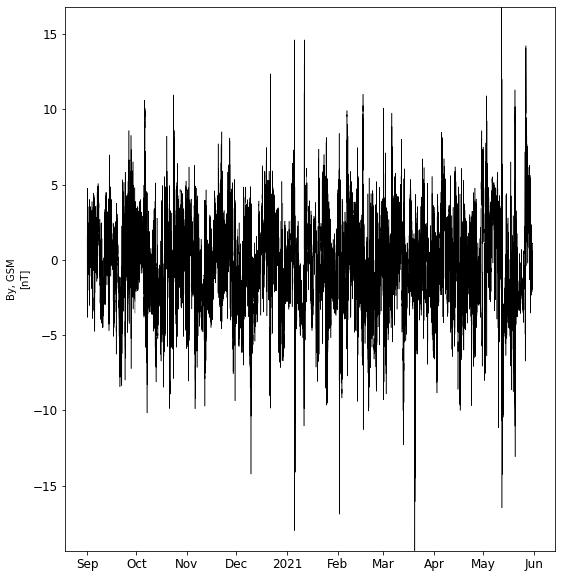

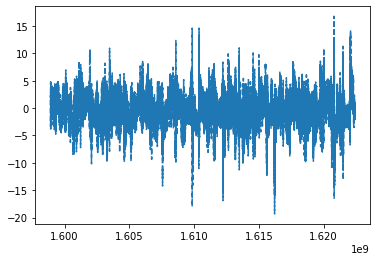

In [4]:
### Confirm loaded tplot variables match above input date by tploting 'BY_GSM' and plt.plotting 'flow_test'
tplot_names()
tplot('BY_GSM')
plt.plot(By_time, By_vals, '--');

## Section 2: Map the time stamps of the desired MEC variable, and it's corresponding time array, to the time cadence of the OMNI variables
* Default MEC variables have a 30s time cadence compared to the default 5min OMNI variable time cadence
* This will create "mms1_mec_r_gsm-itrp" with the same time stamps as "BY_GSM".
    * the variable we're interpolating too must be a tplot variable
    * interpol feature works if I rename an extracted tplot variable
    
* Yr Nightside MEC data has duplicate data point

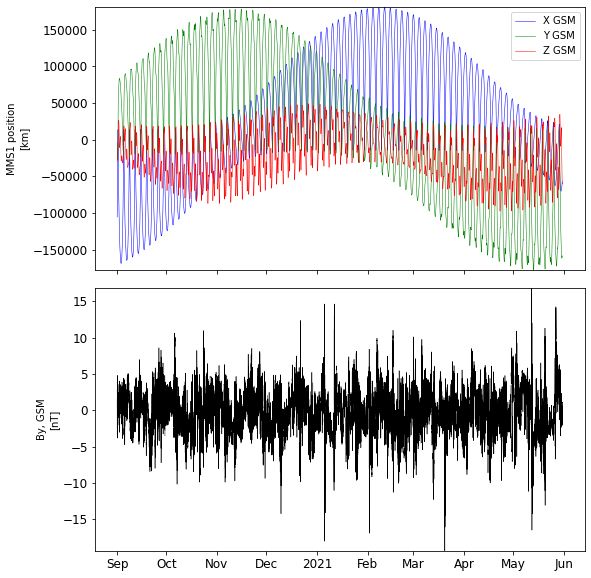

tinterpol (linear) was applied to: mms1_mec_r_gsm-itrp
0 : IMF
1 : PLS
2 : IMF_PTS
3 : PLS_PTS
4 : percent_interp
5 : Timeshift
6 : RMS_Timeshift
7 : Time_btwn_obs
8 : F
9 : BX_GSE
10 : BY_GSE
11 : BZ_GSE
12 : BY_GSM
13 : BZ_GSM
14 : RMS_SD_B
15 : RMS_SD_fld_vec
16 : flow_speed
17 : Vx
18 : Vy
19 : Vz
20 : proton_density
21 : T
22 : NaNp_Ratio
23 : Pressure
24 : E
25 : Beta
26 : Mach_num
27 : Mgs_mach_num
28 : x
29 : y
30 : z
31 : BSN_x
32 : BSN_y
33 : BSN_z
34 : AE_INDEX
35 : AL_INDEX
36 : AU_INDEX
37 : SYM_D
38 : SYM_H
39 : ASY_D
40 : ASY_H
41 : PR-FLX_10
42 : PR-FLX_30
43 : PR-FLX_60
44 : mms1_mec_dipole_tilt
45 : mms1_mec_gmst
46 : mms1_mec_mlat
47 : mms1_mec_mlt
48 : mms1_mec_l_dipole
49 : mms1_mec_quat_eci_to_bcs
50 : mms1_mec_quat_eci_to_dbcs
51 : mms1_mec_quat_eci_to_dmpa
52 : mms1_mec_quat_eci_to_smpa
53 : mms1_mec_quat_eci_to_dsl
54 : mms1_mec_quat_eci_to_ssl
55 : mms1_mec_L_vec
56 : mms1_mec_Z_vec
57 : mms1_mec_P_vec
58 : mms1_mec_L_phase
59 : mms1_mec_Z_phase
60 : mms1_mec_

In [5]:
##use the tinterpol() to map the time stamps of whichever MEC variable, and it's corresponding time array, to the
## time cadence of the OMNI variable
def do_omni_interpolate():
    """Uses tinterpol() to map MEC position variable onto OMNI data to match 5min time cadence. This will 
    create 'mms1_mec_r_gsm-itrp' with the same time stamps as 'BY_GSM'."""
    #store_data('By_vals', data={'x': By_time, 'y': By_vals})
    tplot(['mms1_mec_r_gsm', 'BY_GSM'])
    tinterpol('mms1_mec_r_gsm', 'BY_GSM') #the variable we're interpolating too must be a tplot variable
    tplot_names()
    return;
    
do_omni_interpolate()




##From Eric, find duplicate point in data
### tinterpol requires the variables to be monotonically increasing, 
###and it looks like 'mms1_mec_r_gsm' has a duplicate point at the year 2016-2017 boundary:
def remove_dup_and_interp():
    """With instructions from Eric, tinterpol requires variables with monotonically increasing data. We can
    the data point by avoiding this boundary or deleting the duplicate point with the following code"""
    #Find index where duplicate point occures
    d = get_data('mms1_mec_r_gsm')
    wherenonmono = np.where(d.times[0:-1] >= d.times[1:])
    #Display duplicate timestamps and index
    print(wherenonmono) #it's a tuple
    dup_index = (wherenonmono[0][0])
    print('Duplicate index is:', dup_index)
    print(time_string(d.times[dup_index]))
    #The next timestamp is a duplicate:
    print(time_string(d.times[dup_index+1]))
    """Eric's pyPSEDAS fix: You can fix this data point by avoiding this boundary, 
    or by deleting the duplicate point with:"""
    new_data = np.delete(d.y, dup_index, axis=0)
    new_times = np.delete(d.times, dup_index)
    store_data('mms1_mec_r_gsm_fixed', {'x': new_times, 'y': new_data})
    tinterpol('mms1_mec_r_gsm_fixed', 'BY_GSM') #map mec_rpos data onto OMNI 5min time cadence
    return;

#remove_dup_and_interp()

0 : IMF
1 : PLS
2 : IMF_PTS
3 : PLS_PTS
4 : percent_interp
5 : Timeshift
6 : RMS_Timeshift
7 : Time_btwn_obs
8 : F
9 : BX_GSE
10 : BY_GSE
11 : BZ_GSE
12 : BY_GSM
13 : BZ_GSM
14 : RMS_SD_B
15 : RMS_SD_fld_vec
16 : flow_speed
17 : Vx
18 : Vy
19 : Vz
20 : proton_density
21 : T
22 : NaNp_Ratio
23 : Pressure
24 : E
25 : Beta
26 : Mach_num
27 : Mgs_mach_num
28 : x
29 : y
30 : z
31 : BSN_x
32 : BSN_y
33 : BSN_z
34 : AE_INDEX
35 : AL_INDEX
36 : AU_INDEX
37 : SYM_D
38 : SYM_H
39 : ASY_D
40 : ASY_H
41 : PR-FLX_10
42 : PR-FLX_30
43 : PR-FLX_60
44 : mms1_mec_dipole_tilt
45 : mms1_mec_gmst
46 : mms1_mec_mlat
47 : mms1_mec_mlt
48 : mms1_mec_l_dipole
49 : mms1_mec_quat_eci_to_bcs
50 : mms1_mec_quat_eci_to_dbcs
51 : mms1_mec_quat_eci_to_dmpa
52 : mms1_mec_quat_eci_to_smpa
53 : mms1_mec_quat_eci_to_dsl
54 : mms1_mec_quat_eci_to_ssl
55 : mms1_mec_L_vec
56 : mms1_mec_Z_vec
57 : mms1_mec_P_vec
58 : mms1_mec_L_phase
59 : mms1_mec_Z_phase
60 : mms1_mec_P_phase
61 : mms1_mec_kp
62 : mms1_mec_dst
63 : mms1_me

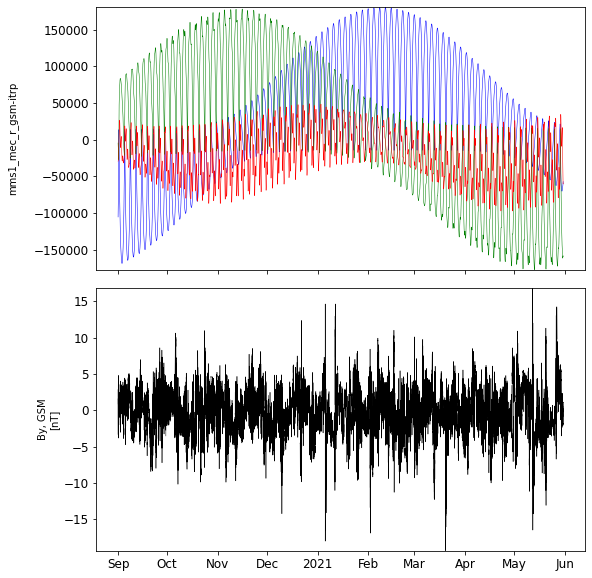

In [6]:
tplot_names();
tplot(['mms1_mec_r_gsm-itrp','BY_GSM'])
#tplot(['mms1_mec_r_gsm_fixed-itrp','BY_GSM'])


### Section 3: Extract Interp-MEC posData and Export as npz Files 

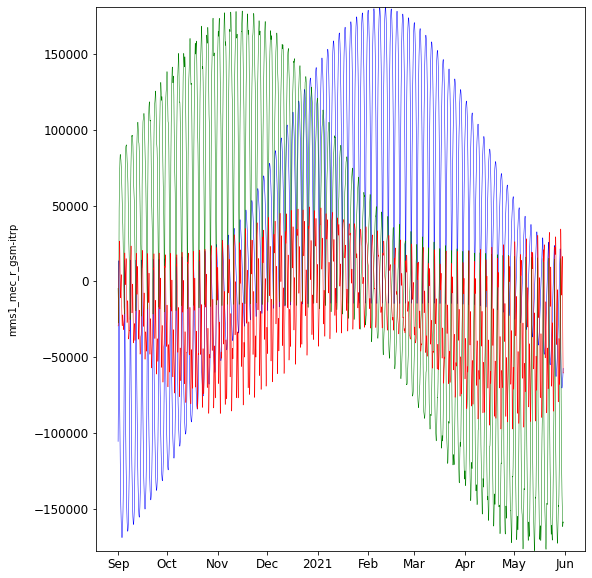

['2020-09-01 00:00:00.000000', '2020-09-01 00:05:00.000000', '2020-09-01 00:10:00.000000', '2020-09-01 00:15:00.000000', '2020-09-01 00:20:00.000000', '2020-09-01 00:25:00.000000', '2020-09-01 00:30:00.000000', '2020-09-01 00:35:00.000000', '2020-09-01 00:40:00.000000', '2020-09-01 00:45:00.000000'] 
 [[-105398.94259929   -4550.93128223  -29337.63190783]
 [-104907.02868278   -4791.00752627  -29348.31681639]
 [-104412.23826178   -5033.13976555  -29357.30641872]
 [-103914.54629057   -5277.30193339  -29364.54074307]
 [-103413.93336597   -5523.46540906  -29369.96048634]
 [-102910.37031177   -5771.600892    -29373.50594245]
 [-102403.83387784   -6021.67616737  -29375.11828539]
 [-101894.29994734   -6273.65747774  -29374.73894601]
 [-101381.74200305   -6527.51011118  -29372.30877168]
 [-100866.13668597   -6783.19644116  -29367.77007385]]

Confirming loaded intrp-MEC data range: 2020-09-01 to 2021-05-31 00:00:00.
OMNI and interp-MEC time arrays are identical:  True


In [7]:
##Extract and define interpolated-MEC position and time arrays
def get_mec_pos(flowv_time):
#After using interpol to match mec_r_gsm time cadence to flow speed, confirm time array matches og 'By_time'
# and extract position data
    #tplot(['mms1_mec_r_gsm_fixed-itrp', 'mms1_mec_r_gsm_fixed'])
    #tplot(['mms1_mec_r_gsm_fixed-itrp'])
    tplot(['mms1_mec_r_gsm-itrp'])
    pos_time, rpos = get_data('mms1_mec_r_gsm-itrp') #extracting both time and vector position array(unit = km)
    #Defining string variables for intrp-MEC start and end time
    achMEC_start = time_string(pos_time[0])
    achMEC_end = time_string(pos_time[-1])
    print(time_string(pos_time[:10]),'\n', rpos[:10])
    print('\nConfirming loaded intrp-MEC data range: %s to %s' %(achMEC_start[0:10], achMEC_end[0:20]));
    print('OMNI and interp-MEC time arrays are identical: ',np.array_equal(pos_time, flowv_time))
    rpos_mag = np.sqrt(rpos[:,0]**2 + rpos[:,1]**2 + rpos[:,2]**2)
    
    # Defining copy of the time array with Bmag's nanvalue locations(errors occur with modifying orginal)
    #time_nan = copy.deepcopy(afUtime) #create copy of array(can modify copy without affecting the original array)
    return (pos_time, rpos[:,0], rpos[:,1], rpos[:,2], rpos_mag);

(afRtime, afXgsm, afYgsm, afZgsm, afRmag_gsm) = get_mec_pos(By_time)




Not exluding nan-values, og and copy are the same: False
Exlcuding nan-values, og and copy are the same: True
Avg relative error is 0.0
MEC time:
 ['2020-09-01 00:00:00.000000', '2020-09-01 00:05:00.000000', '2020-09-01 00:10:00.000000', '2020-09-01 00:15:00.000000', '2020-09-01 00:20:00.000000', '2020-09-01 00:25:00.000000', '2020-09-01 00:30:00.000000', '2020-09-01 00:35:00.000000', '2020-09-01 00:40:00.000000', '2020-09-01 00:45:00.000000'] 
 MEC rmag(in km):
 [109500.43252218 109040.18580377 108577.6194015  108112.7147912
 107645.45909288 107175.83004537 106703.8113238  106229.38589699
 105752.53435452 105273.24067883]


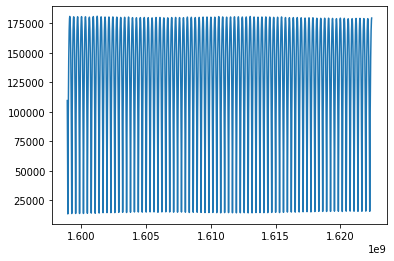

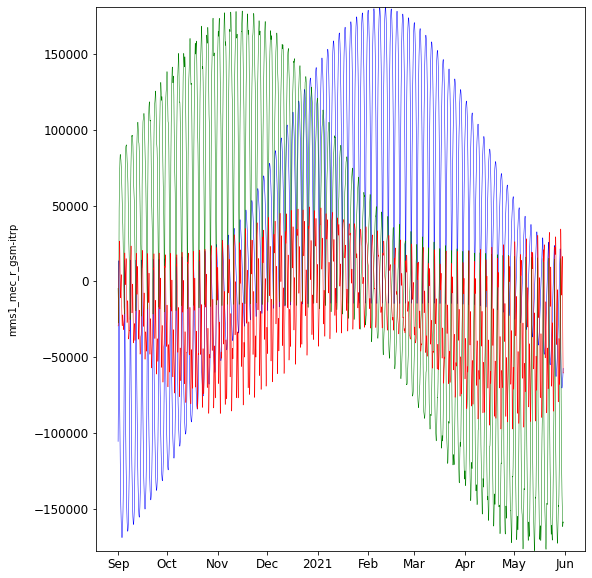

In [9]:
def compare_rmag_copy():
    """Creates copy of afRmag_gsm and compares it to original with the following tests"""
    rmag_copy = copy.deepcopy(afRmag_gsm)
    print('Not exluding nan-values, og and copy are the same:', np.array_equal(rmag_copy, afRmag_gsm))
    print('Exlcuding nan-values, og and copy are the same:',
          np.array_equal(rmag_copy[~np.isnan(rmag_copy)], afRmag_gsm[~np.isnan(afRmag_gsm)]))

    Rcopy_trim = rmag_copy[~np.isnan(rmag_copy)]
    Rog_trim = afRmag_gsm[~np.isnan(afRmag_gsm)]

    ###Calculation for avg relative error between OG and copy array
    fSum = 0
    for i in range(len(Rcopy_trim)):
        if np.abs(Rcopy_trim[i]-Rog_trim[i]) != np.nan:
            fSum = fSum + np.abs(Rcopy_trim[i]-Rog_trim[i])/Rog_trim[i]

    print('Avg relative error is', fSum/len(Rcopy_trim))
    return;

def display_rmag():
    """Displays extracted Rmag array and r_gsm-itrp tplot variable"""
    print('MEC time:\n',time_string(afRtime[:10]),'\n MEC rmag(in km):\n', afRmag_gsm[:10])
    plt.plot(afRtime, afRmag_gsm, '-')
    tplot('mms1_mec_r_gsm-itrp')
    #tplot('mms1_mec_r_gsm_fixed-itrp')
    return;


compare_rmag_copy()
display_rmag()

##################MAIN EXPORT BELOW###########
##Export/save test mec position and time arrays as npz file
#np.savez('Dayside_yr6_MECgsm_posdata.npz', t = afRtime, x = afXgsm, y = afYgsm, z = afZgsm, rmag = afRmag_gsm)



In [ ]:
##Export/save test mec position and time arrays as npz file
#np.savez('yr2_MECgsm_posdata.npz', t = afRtime, x = afXgsm, y = afYgsm, z = afZgsm, rmag = afRmag_gsm)

#np.save('test_mec_time.npy', afR_time)
#np.save('test_mec_rmag.npy', afRmag_gsm)
#np.savetxt('test2_rmag.txt', afRmag_gsm, fmt = '%f') 

### Note on comparing original and re-imported array
* For some odd reason when using np.array_equal() to compare imported and original array, that code and any other personal algorithm breaks. Only when nan-values are excluded, do they reveal the truth of them being the same array 
    * Additionally, in the event that the arrays don't exactly match(to some nth decimal place), computing the average relative error between the arrays yields $\approx 10^{-12}$. Which is an acceptable tolerance
    * Nan-values are trimmed becuase in spite of the imported and original arrays sharing the same nan-value locations, with all other elements being the same. Using any comparitive algorithm doesn't uphold the truth of them  being the same array. In further analysis, it seems that their resoective nan-values don't match
    * Seemingly only occurs with pyspedas extracted data arrays
    
* As indicated by stackexchange, when comparing arrays that contain nan-values, I need to input some command or code that ensures the nan-values of both arrays are the same less I get a false error when comparing
    * https://stackoverflow.com/questions/10710328/comparing-numpy-arrays-containing-nan
        * np.allclose has a feature which enables all nanvalues to be equal
    * NaN values never compare equal. That is, the test NaN==NaN is always False by definition of NaN.

In [10]:
def namestr(obj, namespace):
## (as defined by the a stackoverflowuser) returns name of object as a string list
    return [name for name in namespace if namespace[name] is obj]
def compare_arrays(data1, data2):
#Compares arrays that contain nan-values by first comparing nan-value locations and then arrays without nan-vals
## turns out by default (Nan == Nan) returns false by definition, hence this here function
    print('\nData arrays whose elements are being compared:\n', 
          namestr(data1, globals()),namestr(data2, globals()))
    print('Lengths of inputted data arrays are respectively %d and %d'%(len(data1), len(data2)))
    anNan1 = np.argwhere(np.isnan(data1)) #define array of indices of nan-values
    anNan2 = np.argwhere(np.isnan(data2))
    print('Length of anNan1 and anNan2 are respectively %d and %d' %(len(anNan1), len(anNan2)))
    bJustnans = np.array_equal(anNan1, anNan2) #check if nan-value indices are the same
    bNonans = np.array_equal(data1[~np.isnan(data1)], data2[~np.isnan(data2)])#check if arrays w/out nan-values are the same
    if bJustnans == True and bNonans == True: #arrays match for same nan-value locations and matching elements
        print('Both original and exported arrays are the same')
    else:
        print('Original and exported arrays are not the same :(')
    return;

In [11]:
##Load npz test mec position and time arrays
yrX_load_MECposdata = np.load('Dayside_yr6_MECgsm_posdata.npz')
print(sorted(yrX_load_MECposdata))

#'''
test_MECtime = yrX_load_MECposdata['t']
test_MECx = yrX_load_MECposdata['x']
test_MECy = yrX_load_MECposdata['y']
test_MECz = yrX_load_MECposdata['z']
test_MECr = yrX_load_MECposdata['rmag']

print(time_string(test_MECtime[0]),'\n', time_string(test_MECtime[-1]))


###Using np.array_equal and np.allclose to compare original and exported arrays
##Displaying if imported and exported arrays match as they should
#[~np.isnan] is used becuase for some reason, the nan-values of both arrays, which share the same location and type
# don't match
print('OG interp-MEC time and loaded time arrays match:', np.array_equal(afRtime, test_MECtime))

print('Exluding nan-values, OG interp-MEC rmag and loaded rmag arrays match:', 
      np.array_equal(afRmag_gsm[~np.isnan(afRmag_gsm)], test_MECr[~np.isnan(afRmag_gsm)]))

print('Exluding nan-values, OG interp-MEC and loaded X-arrays match:', 
      np.array_equal(afXgsm[~np.isnan(afXgsm)], test_MECx[~np.isnan(test_MECx)]))

print('Exluding nan-values, OG interp-MEC and loaded Y-arrays match:', 
      np.array_equal(afYgsm[~np.isnan(afYgsm)], test_MECy[~np.isnan(test_MECy)]))

print('Exluding nan-values, OG interp-MEC and loaded Z-arrays match:', 
      np.array_equal(afZgsm[~np.isnan(afZgsm)], test_MECz[~np.isnan(test_MECz)]))


##Ensuring both arrays nan-values are the same when comparing
print('Using np.allclose, OG and loaded rmag arrays match:',np.allclose(afRmag_gsm, test_MECr, equal_nan = True))
print('Using np.allclose, OG and loaded x arrays match:',np.allclose(afXgsm, test_MECx, equal_nan = True)) 
print('Using np.allclose, OG and loaded y arrays match:',np.allclose(afYgsm, test_MECy, equal_nan = True)) 
print('Using np.allclose, OG and loaded z arrays match:',np.allclose(afZgsm, test_MECz, equal_nan = True)) 



#''';

['rmag', 't', 'x', 'y', 'z']
2020-09-01 00:00:00.000000 
 2021-05-31 00:00:00.000000
OG interp-MEC time and loaded time arrays match: True
Exluding nan-values, OG interp-MEC rmag and loaded rmag arrays match: True
Exluding nan-values, OG interp-MEC and loaded X-arrays match: True
Exluding nan-values, OG interp-MEC and loaded Y-arrays match: True
Exluding nan-values, OG interp-MEC and loaded Z-arrays match: True
Using np.allclose, OG and loaded rmag arrays match: True
Using np.allclose, OG and loaded x arrays match: True
Using np.allclose, OG and loaded y arrays match: True
Using np.allclose, OG and loaded z arrays match: True


In [12]:
##Using custom function to compare arrays
print(time_string(test_MECtime[:5]), '\n', time_string(test_MECtime[-5:]))
    #^---displaying 1st and last 5 elements of the array
compare_arrays(afRmag_gsm, test_MECr)
compare_arrays(afXgsm, test_MECx)
compare_arrays(afYgsm, test_MECy)
compare_arrays(afZgsm, test_MECz)

['2020-09-01 00:00:00.000000', '2020-09-01 00:05:00.000000', '2020-09-01 00:10:00.000000', '2020-09-01 00:15:00.000000', '2020-09-01 00:20:00.000000'] 
 ['2021-05-30 23:40:00.000000', '2021-05-30 23:45:00.000000', '2021-05-30 23:50:00.000000', '2021-05-30 23:55:00.000000', '2021-05-31 00:00:00.000000']

Data arrays whose elements are being compared:
 ['afRmag_gsm'] ['test_MECr']
Lengths of inputted data arrays are respectively 78337 and 78337
Length of anNan1 and anNan2 are respectively 1 and 1
Both original and exported arrays are the same

Data arrays whose elements are being compared:
 ['afXgsm'] ['test_MECx']
Lengths of inputted data arrays are respectively 78337 and 78337
Length of anNan1 and anNan2 are respectively 1 and 1
Both original and exported arrays are the same

Data arrays whose elements are being compared:
 ['afYgsm'] ['test_MECy']
Lengths of inputted data arrays are respectively 78337 and 78337
Length of anNan1 and anNan2 are respectively 1 and 1
Both original and expo

In [13]:

def checkin_nanvals(Data1, Data2):
#Checks if input data arrays share the same nan-value locations
#Both Nan-arrays should have same legnth and elements(index locations)
    print('\nData arrays whose nanvalue indices are being compared:\n', 
          namestr(Data1, globals()),namestr(Data2, globals()))
    # Define array of nan-value indices and display their properties
    anNan1 = np.argwhere(np.isnan(Data1)) #define array of indices of nan-values
    anNan2 = np.argwhere(np.isnan(Data2))
    print('Length of anNan1 and anNan2 are respectively %d and %d' %(len(anNan1), len(anNan2)))
    #print('\nanNan1 is\n', anNan1, '\nanNan2 is\n', anNan2)
    # Checks if nan-index arrays are equal(same length and elements) using a built in function and for loop
    print('\nUsing np.array_equal(), the nan-index arrays are equal: %s' %np.array_equal(anNan1, anNan2))
    nCount = 0 #initializing counting variable
    if len(anNan1) == len(anNan2): #check if nan-arrays have same length
        for i in range(len(anNan1)):
            #print('Element %d of both arrays(%d and %d) are equal: %s' %(i, anNan1[i][0], anNan2[i][0], 
            if anNan1[i][0]==anNan2[i][0]: #check if nan-arrays share the same elements
                nCount = nCount + 1
        print('\nUsing a for loop')
        if nCount == len(anNan2):
            print('Both nan-index arrays(same length) share the same elements, and thus same nan-value locations')
        else:
            print('They do not share the same nan-value locations')
    else: #Display for if the lengths are not equal
        print('\nNan arrays are not the same length, and thus do not have the same nanvalue locations')
    return;

def same_arrays(Data1, Data2):
#Checks if input data arrays share the same length and elements
    print('\nData arrays whose elements are being compared:\n', 
          namestr(Data1, globals()),namestr(Data2, globals()))
    print('Lengths of inputted data arrays are respectively %d and %d'%(len(Data1), len(Data2)))
    # Checks if arrays are equal(same length and elements) using a built in function and for loop
    print('Using np.array_equal(), the nan-index arrays are equal: %s' %np.array_equal(Data1, Data2))
    nCount = 0 #initializing counting variable
    if len(Data1) == len(Data2): #check if nan-arrays have same length
        for i in range(len(Data1)):
            if Data1[i]==Data2[i]: #check if arrays share the same elements
                nCount = nCount + 1
            else:
                print('No equality at index %d, where (Data1 == %0.2f) != (Data2 == %0.2f)'%(i, Data1[i], Data2[i]))
        print('\nUsing a for loop')
        if nCount == len(Data2):
            print('Both nan-index arrays(same length) share the same elements and index locations')
        else:
            print('They do not share the same element locations')
    else: #Display for if the lengths are not equal
        print('\nNan arrays are not the same length, and thus do not share the same element locations')
    return;




#same_arrays(afRmag_gsm[~np.isnan(afRmag_gsm)], load_rmag[~np.isnan(load_rmag)])

#R_trim = afRmag_gsm[~np.isnan(afRmag_gsm)]
#test2_rtrim = test2_rmag[~np.isnan(test2_rmag)]
#print('Avg relative error = ', np.average(np.abs(R_trim-test2_rtrim)/R_trim))
        
checkin_nanvals(test_MECr, afRmag_gsm)
#print(np.array_equal(afRmag_gsm, afRmag_gsm))
#same_arrays(test_MECx[~np.isnan(test_MECx)], afXgsm[~np.isnan(afXgsm)])
#print(type(test_MECr[288]), type(afRmag_gsm[288]))
#print('Are they equal:', test_MECr[288] == afRmag_gsm[288])

#print(np.allclose(afRmag_gsm, test_MECr, equal_nan = True)) #ensure nan-values in both matrices are the same

#compare_arrays(afXgsm, test_MECx)


Data arrays whose nanvalue indices are being compared:
 ['test_MECr'] ['afRmag_gsm']
Length of anNan1 and anNan2 are respectively 1 and 1

Using np.array_equal(), the nan-index arrays are equal: True

Using a for loop
Both nan-index arrays(same length) share the same elements, and thus same nan-value locations


### Different Methods of exporting array(s) as certain file types

In [ ]:
'''
#Using numpy's savetxt and save to export files as CSV, txt, and npy format
np.savetxt('time_test.csv', Time_test, delimiter = ',') #saving to csv file
np.savetxt('time_test.txt', Time_test, fmt = '%f' )#saving to txt file; gotta know element type
np.save('time_test.npy', Time_test) #saving as NPY(binary) file

np.savez('flowntime.npz', Time_test, Flow_test)
##The loaded arrays are returned from the load() function 
##in a dict with the names ‘arr_0’ for the first array, ‘arr_1’ for the second, and so on.
''';

In [ ]:
'''
##Using loadtxt and load to upload above exported arrays
tim_test1 = np.loadtxt('time_test.csv', delimiter = ',')
tim_test2 = np.loadtxt('time_test.txt', dtype = float) #if a txt file, makes sure you know what type of objects are in the arrays
tim_test3 = np.load('time_test.npy')

test4_npz = np.load('flowntime.npz')
print(sorted(test4_npz))
tim_test4 = test4_npz['arr_0']
#flow_timtest = test4_npz['arr_1']
''';

In [ ]:
'''
print('OG time array matches loaded CSV time array:', np.array_equal(Time_test, tim_test1))
print('OG time array matches loaded txt time array:', np.array_equal(Time_test, tim_test2))
print('OG time array matches loaded npy time array:', np.array_equal(Time_test, tim_test3))
print('OG time array matches loaded npz time array:', np.array_equal(Time_test, tim_test4))
#print('OG flow array matches loaded npz flow array:', np.array_equal(Flow_test, flow_timtest))



print('\n',time_string(Time_test[:10]), '\n', time_string(tim_test1[:10]), '\n', time_string(tim_test2[:10]),
     '\n', time_string(tim_test4[:10]))
''';

## Note on exporting arrays as CSV, txt, or npy(binary) files
* Exporting as npy produces small files[they're in binary] which load up fast, but are unviewable without using np.load; Full Yr ~ 615kb
* Exporting as CSV files are viewable through whatever software, but they're significantly larger files than the others; Full Yr ~ 2mb
* Exporting as txt files are viewable and offer a happy medium between NPY and CSV file sizes; Full Yr ~ 1.5mb

In [ ]:
'''
x = np.linspace(0, 40, 200)
y = np.linspace(0,50,200)
r = np.sqrt(x**2 + y**2)

np.savez('test_genr.npz', x = x, y = y, r = r)

test_gendata = np.load('test_genr.npz')
x_load = test_gendata['x']
print(np.array_equal(x, x_load))
''';

In [ ]:
type(np.inf)

In [ ]:
np.inf == (np.inf**2)